In [1]:
from os.path import join, expanduser
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from astra.torch.models import MLPRegressor
from joblib import delayed, Parallel
from sklearn.linear_model import LinearRegression

from tqdm.notebook import tqdm

import xarray as xr
from optree import tree_map
import matplotlib.pyplot as plt

import statsmodels.api as sm

# set numpy default dtype to float32

In [2]:
dec23 = xr.open_dataset('/home/patel_zeel/aqmsp/aqmsp_data/datasets/cpcb/ijcai24/data_dec23.nc')
dec23

<xarray.Dataset>
Dimensions:                    (time: 744, station: 46)
Coordinates:
  * time                       (time) datetime64[ns] 2023-12-01T00:30:00 ... ...
  * station                    (station) object 'Alipur_Delhi_DPCC' ... 'Wazi...
    lat                        (station) float64 ...
    lon                        (station) float64 ...
    elevation                  (station) float64 ...
    pop_1km                    (station) float64 ...
    pop_2km                    (station) float64 ...
    pop_3km                    (station) float64 ...
    pop_4km                    (station) float64 ...
    pop_5km                    (station) float64 ...
    pop_10km                   (station) float64 ...
    d_motorway                 (station) float64 ...
Data variables: (12/417)
    TSURF_K                    (time, station) float32 ...
    SNOWEW_M                   (time, station) float32 ...
    SNOWAGE_HR                 (time, station) float32 ...
    PRATE_MMpH                 (time, station) float32 ...
    CLOUD_OD                   (time, station) float32 ...
    U10_MpS                    (time, station) float32 ...
    ...                         ...
    UWIND_MpS_LAY0_lag_1       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_2       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_3       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_4       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_5       (time, station) float32 ...
    UWIND_MpS_LAY0_lag_6       (time, station) float32 ...
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2023264
    CTIME:          73659
    WDATE:          2023264
    ...             ...
    VGLVLS:         [0. 0.]
    GDNAM:          ????????????????
    UPNAM:          CAMx2IOAPI      
    VAR-LIST:       TSURF_K         SNOWEW_M        SNOWAGE_HR      PRATE_MMp...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    HISTORY:

## Add temporal features

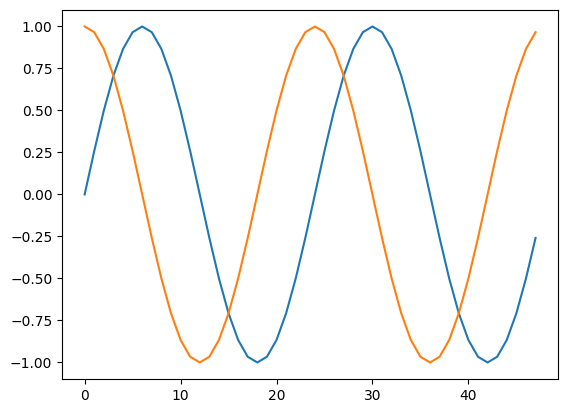

In [25]:
dec23["time_sine"] = np.sin(2 * np.pi * dec23["hour"]/24)
dec23["time_cosine"] = np.cos(2 * np.pi * dec23["hour"]/24)
dec23["invd_motorway"] = 1 / (dec23["d_motorway"] + 1)
plt.plot(dec23.time_sine.values[:, 0].ravel()[:48])
plt.plot(dec23.time_cosine.values[:, 0].ravel()[:48])

In [26]:
features = ["lat", "lon", "time_sine", "time_cosine", "pop_5km", "invd_motorway"]
# features = ["lat", "lon", "hour"]
for fold in range(4):
    print(f"Fold {fold}")
    train_locs = np.load(join(f"/home/patel_zeel/aqmsp/aqmsp_data/datasets/cpcb/ijcai24/fold_{fold}_train.npy"))
    test_locs = np.load(join(f"/home/patel_zeel/aqmsp/aqmsp_data/datasets/cpcb/ijcai24/fold_{fold}_test.npy"))
    print(len(train_locs), len(test_locs))
    
    train_df = dec23.sel(station=train_locs).to_dataframe().reset_index()
    train_df = train_df[train_df["PM2.5_missing"] == False]
    model = LinearRegression()
    
    # create random fourier features
    X = train_df[features].values
    # rffs = np.random.randn(X.shape[1], 100) * 2
    # sines = np.sin(X @ rffs)
    # cosines = np.cos(X @ rffs)
    # X = np.concatenate([sines, cosines], axis=1)
    print(X.shape)
    
    model.fit(X, train_df["PM2.5"])
    
    test_df = dec23.sel(station=test_locs).to_dataframe().reset_index()
    test_df = test_df[test_df["PM2.5_missing"] == False]
    
    X = test_df[features].values
    # sines = np.sin(X @ rffs)
    # cosines = np.cos(X @ rffs)
    # X = np.concatenate([sines, cosines], axis=1)
    
    pred = model.predict(X)
    test_df["PM2.5_pred"] = pred
    rmse = np.sqrt(np.mean((test_df["PM2.5"] - test_df["PM2.5_pred"])**2))
    print(rmse)

# test_df

Fold 0
34 12
(24674, 6)
82.82294906336163
Fold 1
34 12
(24703, 6)
79.67054777252278
Fold 2
35 11
(25270, 6)
77.81254718355034
Fold 3
35 11
(25493, 6)
91.28623525076976
